# *Tutorial: ASM Propagation Options in Pado 🌊*
**Author:** Dong-Ha Shin | **Last Updated:** 2025-03-19

This tutorial explores the enhanced Angular Spectrum Method (ASM) implementation in Pado, showcasing its advanced features beyond conventional ASM.

## 🔍 **Introduction**
Conventional ASM propagation has significant limitations:
- ⚠️ Only supports on-axis propagation
- ⚠️ Requires identical input and output window sizes
- ⚠️ Cannot easily handle different magnifications

In Pado, we've extended the ASM algorithm to overcome these limitations!

## 🚀 **Advanced Features of Pado's ASM**
Our implementation includes these powerful extensions:

- 🏹 **Off-axis propagation**: Simulate light propagation at angles to the optical axis
- 🔍 **Scalable output windows**: Change magnification with the scaling factor parameter
- 🔄 **Linear/circular convolution options**: Choose the appropriate boundary conditions
- 🔎 **Band-limiting control**: Enable/disable frequency filtering for better numerical stability

## 💡 **How to Use These Features**
This notebook demonstrates how these parameters affect light propagation through various examples:
- Different scaling factors (`b` parameter)
- Various lateral shifts (`offset` parameter)
- Linear vs. circular convolution modes
- With and without band-limiting

## 🧪 **Practical Applications**
These extensions enable simulating realistic optical systems like:
- Off-axis imaging systems
- Magnifying optical arrangements
- Systems with angled components

In [1]:
cd ../..

c:\Users\PC\Desktop\pado


In [2]:
import pado
import torch
import matplotlib.pyplot as plt

from pado.math import nm, um

In [3]:
R = 200  # number of rows
C = 200  # number of columns
pitch = 3*um  # physical size of each pixel

wvl = 521*nm  
dim = (1, 1, R, C)  # dimension of the light [batch, channel, row, column], 3 channels for R-G-B

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda:0


In [4]:
light = pado.light.Light(dim,pitch,wvl,device=device)

f = 50e-3  # focal length
lens = pado.optical_element.RefractiveLens(dim,pitch,f,wvl,device)
aperture = pado.optical_element.Aperture(dim, pitch, R*pitch, 'circle', wvl, device)


In [5]:
# Let's explore various ASM options with a helper function
def propagate_with_options(light_source, lens, aperture, distance, 
                          offset=(0, 0), linear=True, band_limit=True, 
                          scaling_factor=1.0):
    """
    Propagate light with specific ASM options
    
    Args:
        light_source: Source light object
        lens: Lens object
        aperture: Aperture object
        distance: Propagation distance
        offset: (y, x) lateral shift in meters
        linear: Whether to use linear convolution (with padding)
        band_limit: Apply band-limiting filter
        scaling_factor: Scaling factor for observation plane (b>1: expansion, b<1: focusing)
    
    Returns:
        Propagated light object
    """
    light_after_lens = lens.forward(light_source.clone())
    light_after_aperture = aperture.forward(light_after_lens)
    
    # Create propagator with specified options
    prop = pado.propagator.Propagator('ASM')
    
    # Propagate with the given options
    light_after_prop = prop.forward(light_after_aperture, distance, 
                                   offset=offset, 
                                   linear=linear,
                                   band_limit=band_limit,
                                   b=scaling_factor)
    
    return light_after_prop

Default ASM propagation (linear=True, band_limit=True, b=1.0, offset=(0,0))


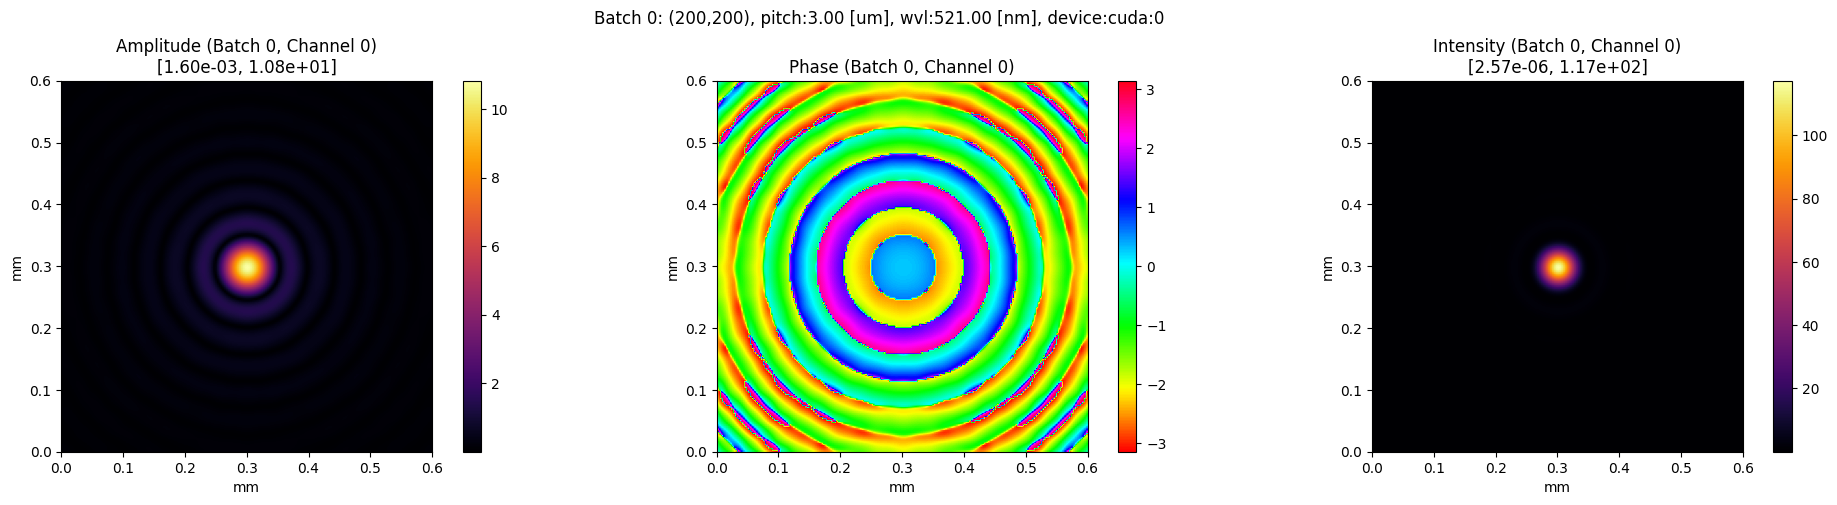

ASM with non-padded convolution (linear=False)


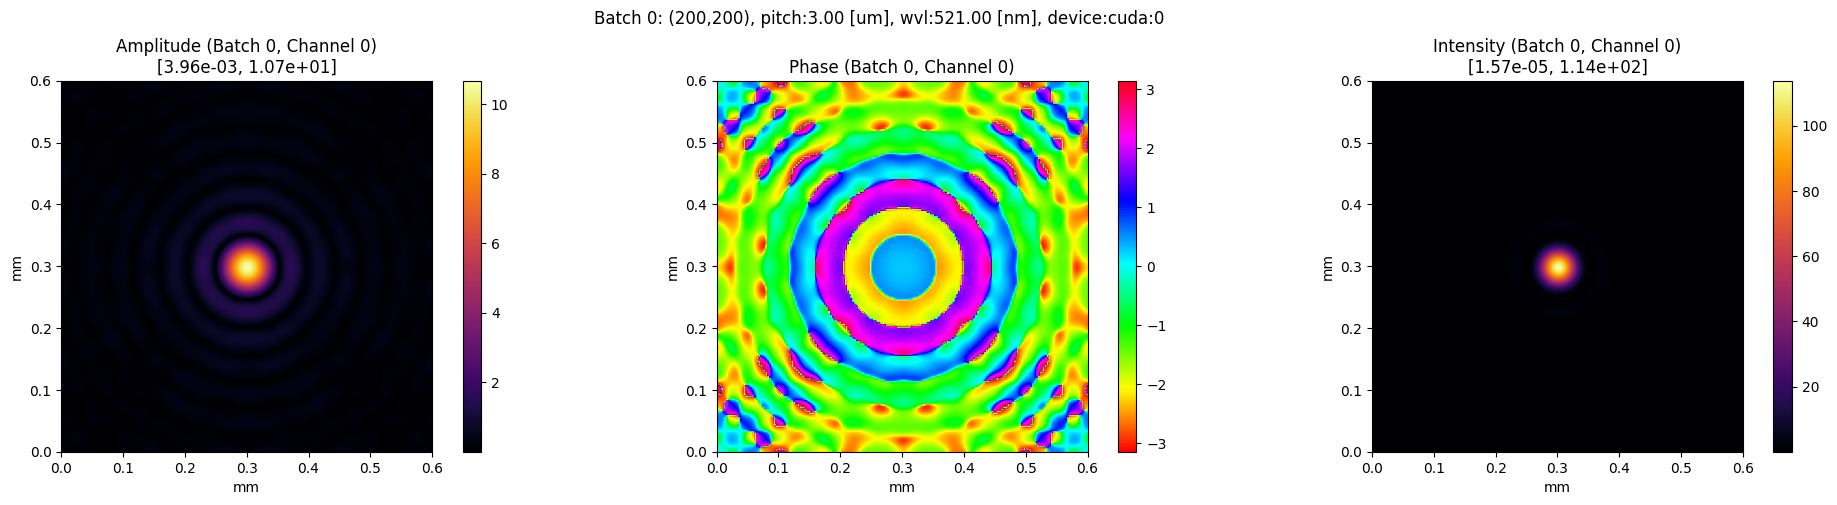

ASM without band-limiting (band_limit=False)


Scaling factor effects (observation plane scaling)

ASM with scaling factor b=0.1 (b<1: focusing, b>1: expansion)



ASM with scaling factor b=0.5 (b<1: focusing, b>1: expansion)


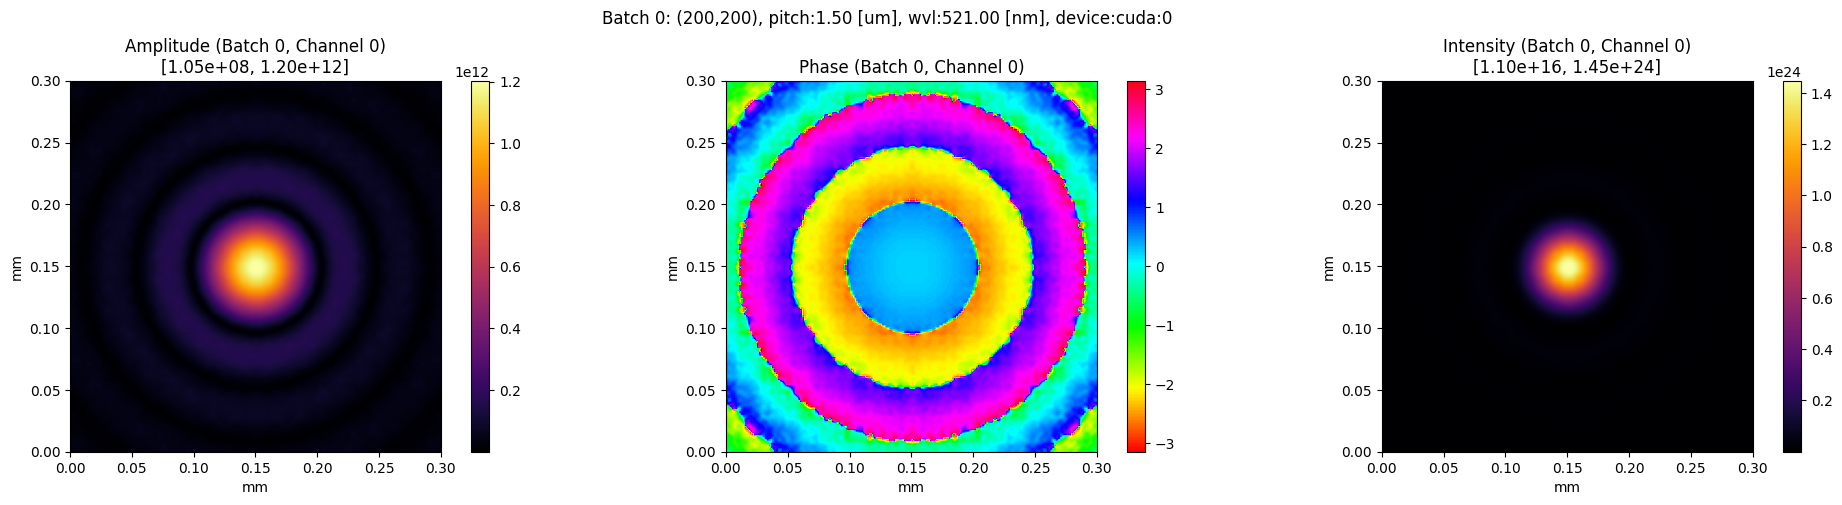


ASM with scaling factor b=2.0 (b<1: focusing, b>1: expansion)


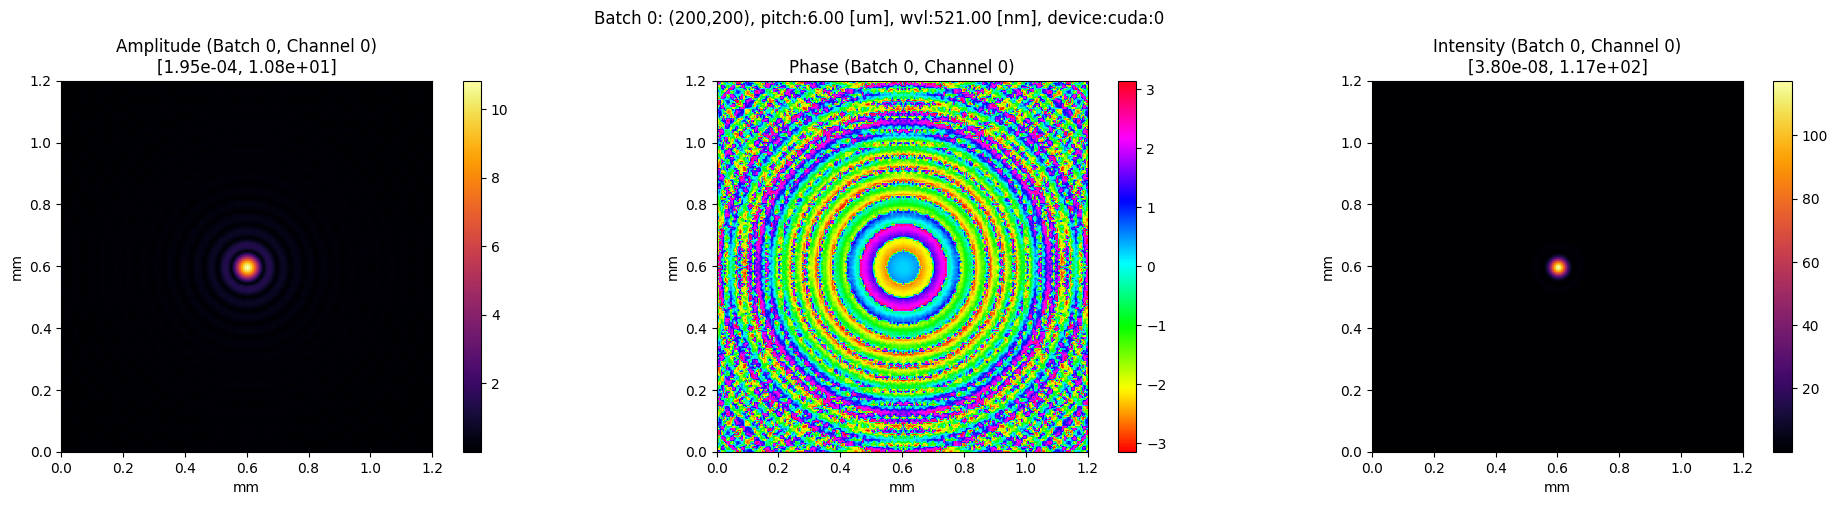


ASM with scaling factor b=4.0 (b<1: focusing, b>1: expansion)


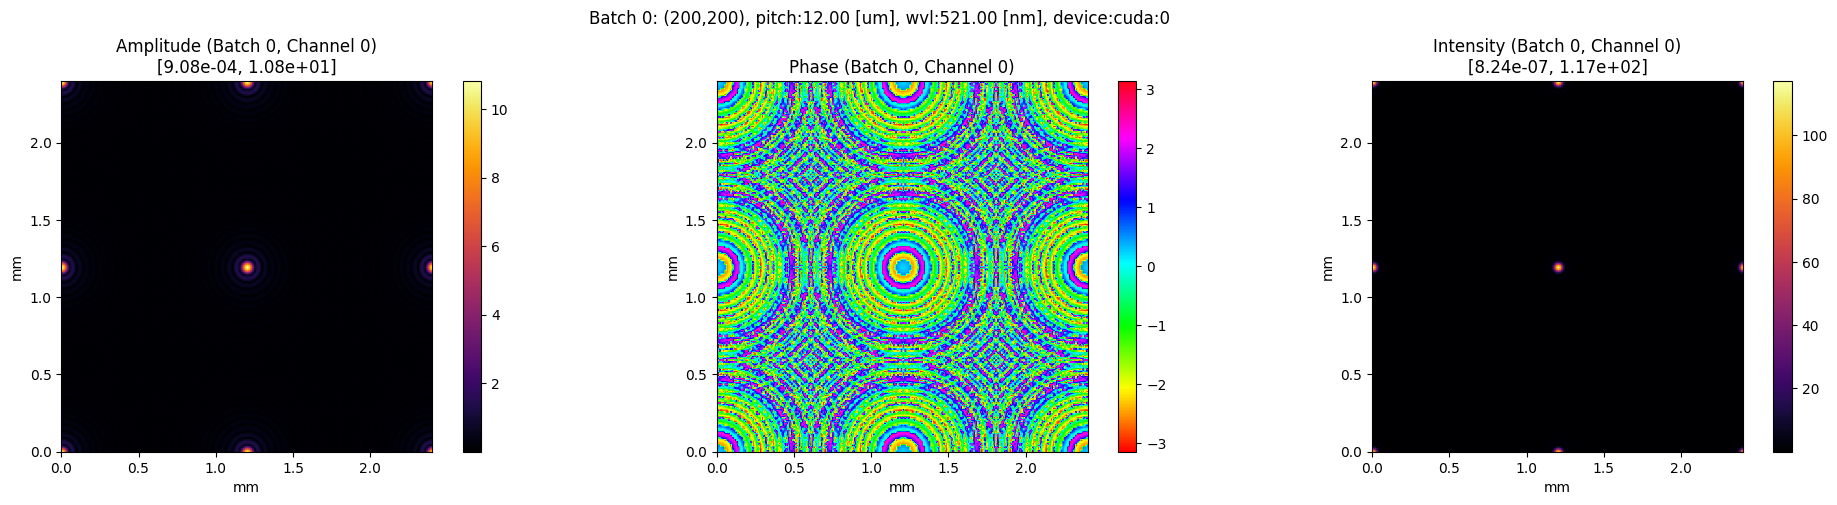

Off-axis propagation with lateral shifts

ASM with offset (y=200.0μm, x=0.0μm)


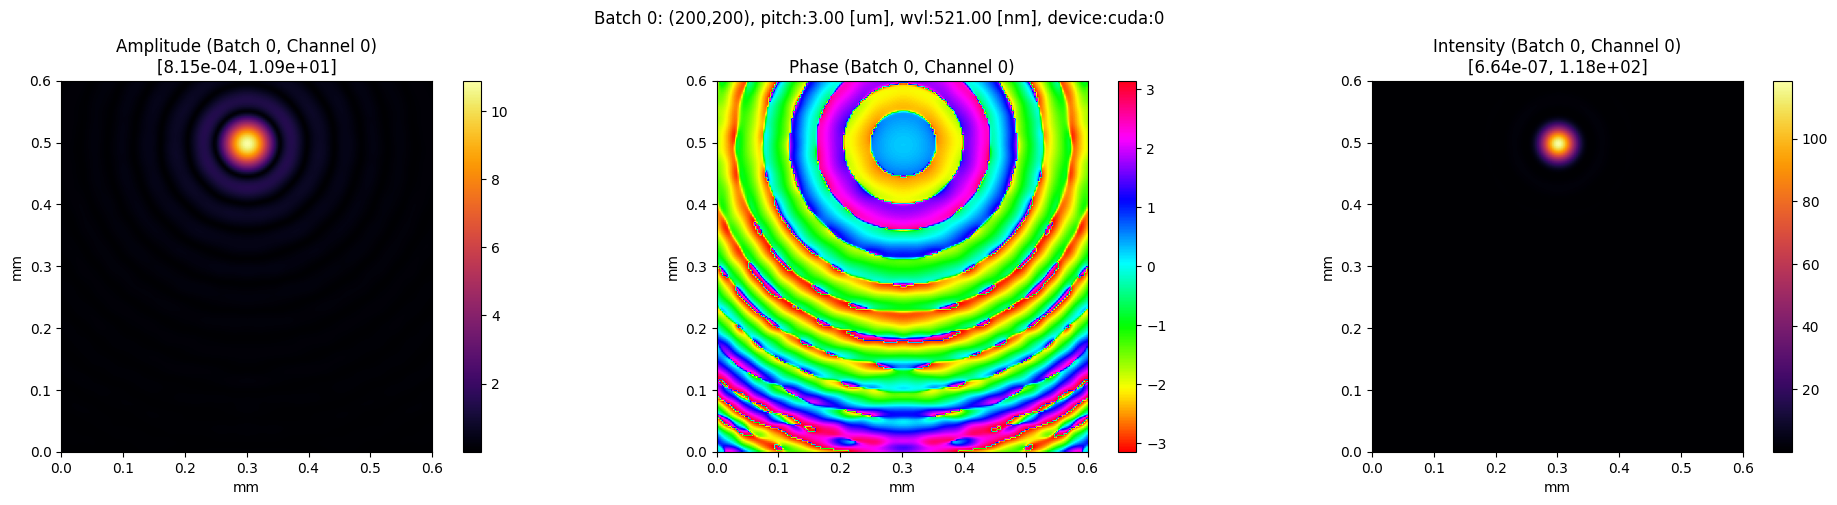


ASM with offset (y=0.0μm, x=200.0μm)


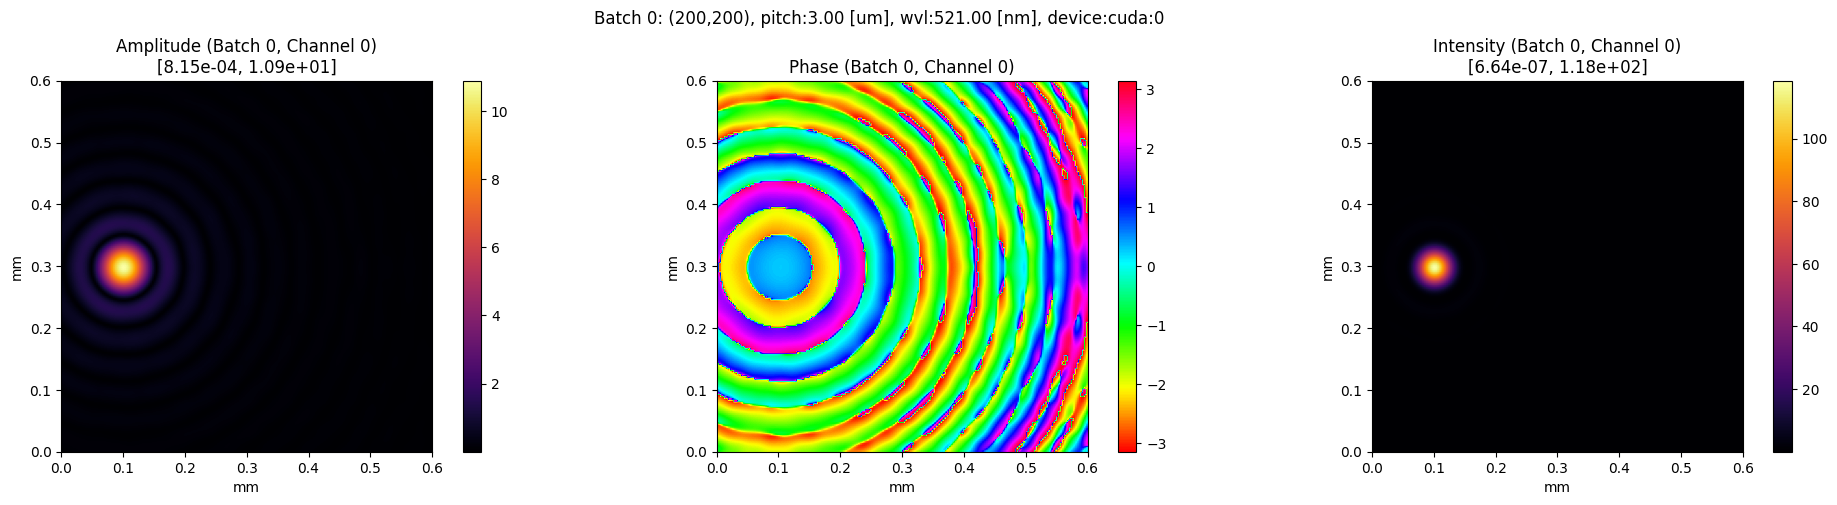


ASM with offset (y=200.0μm, x=200.0μm)


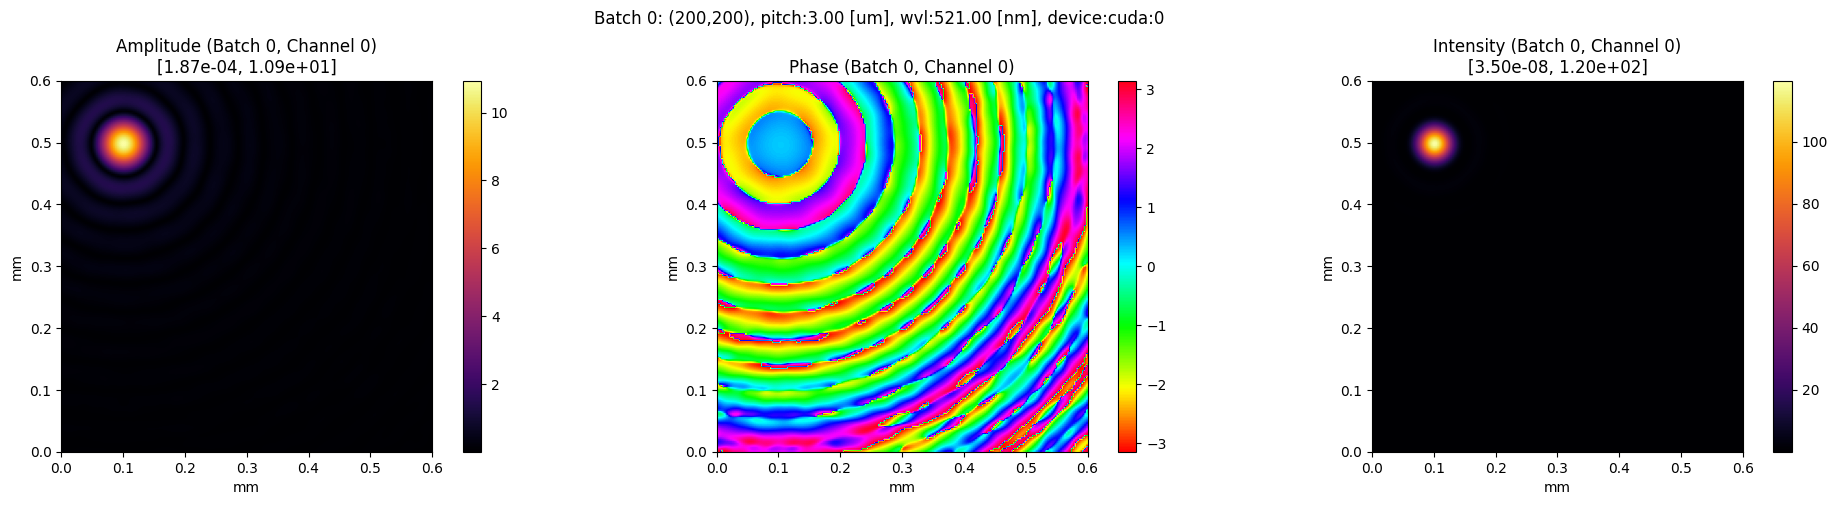


ASM with offset (y=-200.0μm, x=-200.0μm)


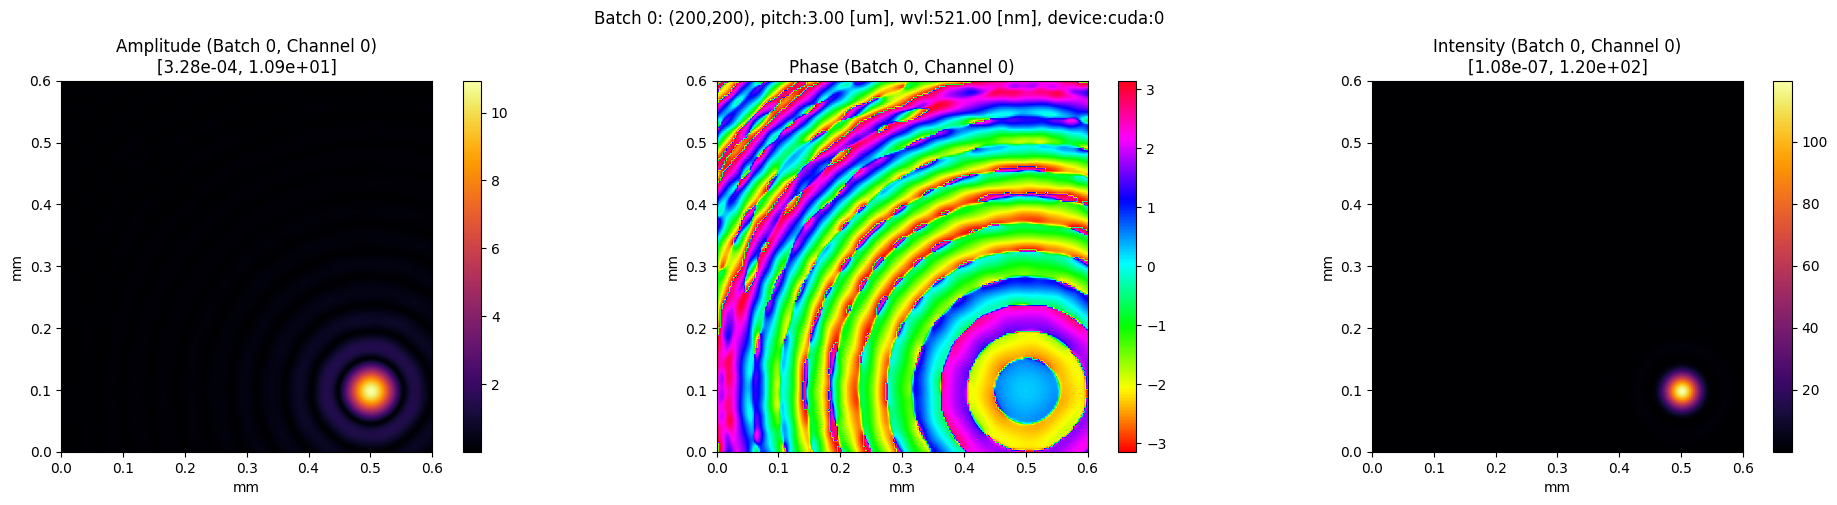

In [6]:
light_default = propagate_with_options(light, lens, aperture, f)
print("Default ASM propagation (linear=True, band_limit=True, b=1.0, offset=(0,0))")
light_default.visualize()

light_circular = propagate_with_options(light, lens, aperture, f, linear=False)
print("ASM with non-padded convolution (linear=False)")
light_circular.visualize()

light_no_band_limit = propagate_with_options(light, lens, aperture, f, band_limit=False)
print("ASM without band-limiting (band_limit=False)")
light_no_band_limit.visualize()

print("Scaling factor effects (observation plane scaling)")
for b in [0.1, 0.5, 2.0, 4.0]:
    light_scaled = propagate_with_options(light, lens, aperture, f, scaling_factor=b)
    print(f"\nASM with scaling factor b={b} (b<1: focusing, b>1: expansion)")
    light_scaled.visualize()

print("Off-axis propagation with lateral shifts")
offsets = [      
    (200*um, 0), # Shift right 100 microns
    (0, 200*um), # Shift down 100 microns
    (200*um, 200*um), # Shift right and down 100 microns
    (-200*um, -200*um), # Shift left and up 100 microns
]

for offset in offsets:
    y_offset, x_offset = offset
    light_offset = propagate_with_options(light, lens, aperture, f, offset=offset)
    print(f"\nASM with offset (y={y_offset*1e6:.1f}μm, x={x_offset*1e6:.1f}μm)")
    light_offset.visualize(uniform_scale=False)